In [170]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
from IPython.display import clear_output
import random
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import TimeSeries, dRSA, print_wise, get_lagplot
from general_utils.II import dynInformationImbalance
from project_specific_utils.dataloader import load_meg_data


In [186]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    sub_num = 3
    run = 1
    neu_fs = 100
    mod_fs = 23.976
    model_name = "pixelwise_lum";
    sq_side = 250
    downsampled_sq_size = 50
    sensors_group = 'occ'
    model_name = "pixelwise_luminance"
    time_points = 200
    pseudotrials_n = 100
cfg = Cfg()

In [187]:
neu, labels = load_meg_data(paths, cfg.sub_num, cfg.run, cfg.sensors_group, cfg.neu_fs)

In [188]:
from image_processing.gaze_dep_models import save_pixelwise_luminance
model_filename = save_pixelwise_luminance(paths, cfg.model_name, cfg.sub_num, cfg.run, cfg.mod_fs, cfg.sq_side, *(cfg.downsampled_sq_size,))
with h5py.File(model_filename, "r") as f:
    mod = f['vecrep'][:]
mod = TimeSeries(mod, cfg.mod_fs)
mod.resample(cfg.neu_fs)
neu.set_array(neu.get_array()[:,:len(mod)])

In [191]:

iteration_n = 20
tot_rsa = np.zeros((cfg.time_points, cfg.time_points))
for i_iter in range(iteration_n):
    print_wise(f"starting iteration {i_iter} of {iteration_n-1} ")
    neu_trials = []
    mod_trials = []
    pseudotrials_idx = random.sample(range(len(neu)- cfg.time_points), cfg.pseudotrials_n )
    for n in pseudotrials_idx:
        neu_trials.append(neu.get_array()[:,n:n+cfg.time_points])
        mod_trials.append(mod.get_array()[:,n:n+cfg.time_points])
    neu_trials = TimeSeries(np.stack(neu_trials, axis=2), cfg.neu_fs)
    mod_trials = TimeSeries(np.stack(mod_trials, axis=2), cfg.neu_fs)
    # drsa_obj_corr = dRSA("correlation")
    drsa_obj_corr = dynInformationImbalance("correlation", "correlation")
    drsa_obj_corr.compute_both_RDM_timeseries(neu_trials, mod_trials)
    drsa_obj_corr.compute_both_distance_ranks_timeseries()
    rsa_corr = drsa_obj_corr.compute_dynII('B2A')    
    tot_rsa += rsa_corr
tot_rsa = tot_rsa/iteration_n

12:08:55 - starting iteration 0 of 19 
12:08:57 - starting iteration 1 of 19 
12:08:57 - starting iteration 2 of 19 
12:08:58 - starting iteration 3 of 19 
12:08:59 - starting iteration 4 of 19 
12:09:00 - starting iteration 5 of 19 
12:09:01 - starting iteration 6 of 19 
12:09:02 - starting iteration 7 of 19 
12:09:03 - starting iteration 8 of 19 
12:09:04 - starting iteration 9 of 19 
12:09:05 - starting iteration 10 of 19 
12:09:05 - starting iteration 11 of 19 
12:09:06 - starting iteration 12 of 19 
12:09:07 - starting iteration 13 of 19 
12:09:08 - starting iteration 14 of 19 
12:09:09 - starting iteration 15 of 19 
12:09:10 - starting iteration 16 of 19 
12:09:10 - starting iteration 17 of 19 
12:09:11 - starting iteration 18 of 19 
12:09:12 - starting iteration 19 of 19 


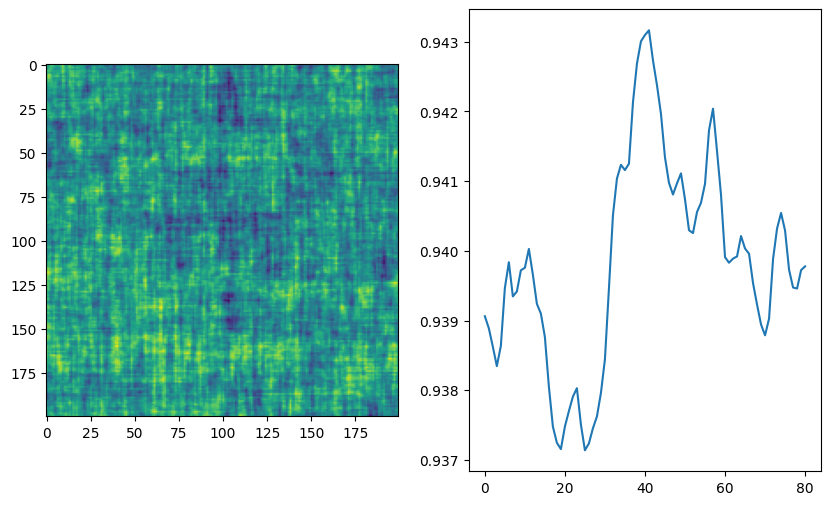

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(tot_rsa)
ax[1].plot(get_lagplot(tot_rsa, max_lag=40))

In [89]:
drsa_obj_corr = dRSA("correlation")
drsa_obj_corr.compute_both_RDM_timeseries(neu_trials, mod_trials)
rsa_corr = drsa_obj_corr.compute_dRSA()
drsa_obj_euc = dRSA("euclidean")
drsa_obj_euc.compute_both_RDM_timeseries(neu_trials, mod_trials)
rsa_euc = drsa_obj_euc.compute_dRSA()
drsa_obj_cos = dRSA("cosine_cnt")
drsa_obj_cos.compute_both_RDM_timeseries(neu_trials, mod_trials)
rsa_cos = drsa_obj_cos.compute_dRSA()

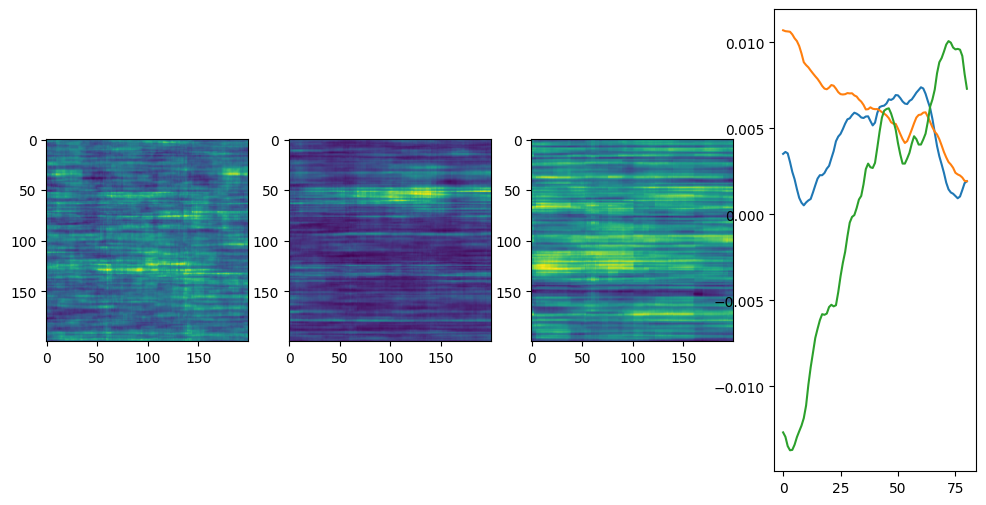

In [93]:
from general_utils.utils import get_lagplot
fig, ax = plt.subplots(1,4, figsize=(12,6))
ax[0].imshow(rsa_corr)
ax[1].imshow(rsa_cos)
ax[2].imshow(rsa_euc)
# fig.colorbar()
ax[3].plot(get_lagplot(rsa_corr, max_lag=40))
ax[3].plot(get_lagplot(rsa_cos, max_lag=40))
ax[3].plot(get_lagplot(rsa_euc, max_lag=40))